In [49]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import patches
from matplotlib import pyplot as plt

root_path = Path().absolute().parents[1]
figures_path = root_path / "common" / "resources" / "images" / "intro"

In [51]:
def convert_volume(volume: str):
    suffix_multipliers = {
        'K': 10 ** 3,
        'M': 10 ** 6,
        'B': 10 ** 9,
    }

    if volume == '-':
        return pd.NA

    if volume[-1] in suffix_multipliers:
        num = float(volume[:-1])
        return int(num * suffix_multipliers[volume[-1]])
    else:
        raise ValueError(f'Volume must end with suffix multiplier, but got {volume}')


data = pd.read_csv("bitcoin.csv")

data['Close'] = data['Price']
data.drop(columns=['Price'], inplace=True)

data[['Open', 'High', 'Low', 'Close']] = data[['Open', 'High', 'Low', 'Close']].apply(lambda x: x.str.replace(',', ''), axis=1)

data['Volume'] = data['Vol.'].apply(convert_volume)
data.drop(columns=['Vol.'], inplace=True)

data.drop(columns=['Change %'], inplace=True)

data['Open'] = pd.to_numeric(data['Open'])
data['High'] = pd.to_numeric(data['High'])
data['Low'] = pd.to_numeric(data['Low'])
data['Close'] = pd.to_numeric(data['Close'])
data['Volume'] = pd.to_numeric(data['Volume'])

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Color'] = np.where(data['Close'] > data['Open'], 'green', 'red')

data['SMA'] = data['Close'].rolling(window=20, center=True).mean()
data['Upper Band'] = data['SMA'] + 2 * data['Close'].rolling(window=20, center=True).std()
data['Lower Band'] = data['SMA'] - 2 * data['Close'].rolling(window=20, center=True).std()

data

,Open,High,Low,Close,Volume,Color,SMA,Upper Band,Lower Band
Date,,,,,,,,,
2024-02-09,45293.3,47710.2,45254.2,47545.4,86850.0,green,NaN,NaN,NaN
2024-02-08,44346.2,45579.2,44336.4,45293.3,66380.0,green,NaN,NaN,NaN
2024-02-07,43088.4,44367.9,42783.5,44339.8,48570.0,green,NaN,NaN,NaN
2024-02-06,42697.6,43375.5,42566.8,43087.7,33320.0,green,NaN,NaN,NaN
2024-02-05,42581.4,43532.2,42272.5,42697.2,39260.0,green,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2010-07-22,0.1,0.1,0.1,0.1,2160.0,red,NaN,NaN,NaN
2010-07-21,0.1,0.1,0.1,0.1,580.0,red,NaN,NaN,NaN
2010-07-20,0.1,0.1,0.1,0.1,260.0,red,NaN,NaN,NaN


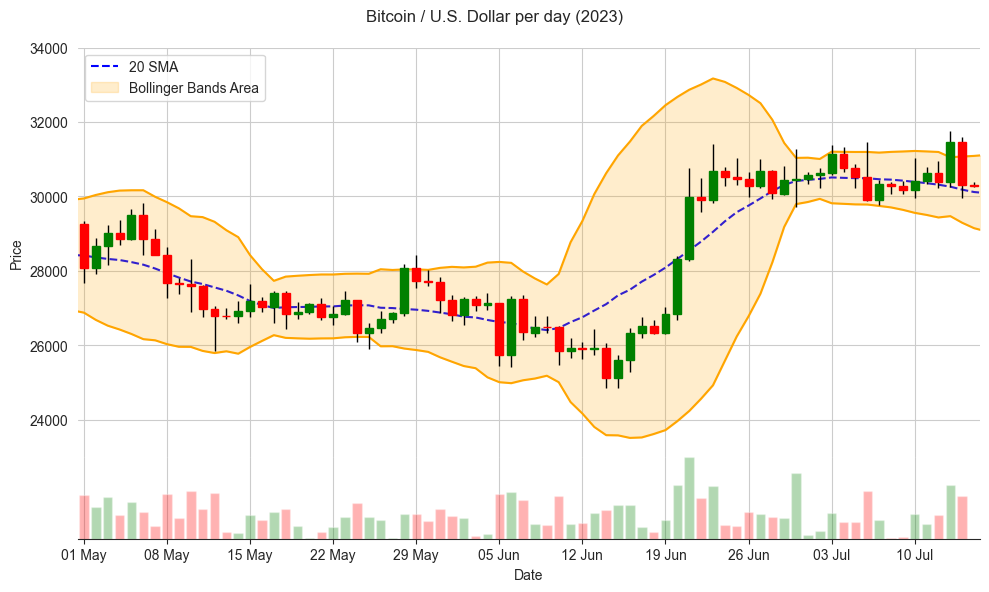

In [54]:
sns.set_style('white', rc={'xtick.bottom': True})

from_date = pd.to_datetime('2023-05-01')
to_date = pd.to_datetime('2023-07-15')


def plot_candle(row: pd.Series, ax):
    ax.vlines(
        x=row.name,
        ymin=row['Low'],
        ymax=row['High'],
        color='black',
        linewidth=1,
        zorder=5,
    )

    bottom = min(row['Open'], row['Close'])
    height = abs(row['Close'] - row['Open'])

    rect = patches.Rectangle(
        (row.name - pd.Timedelta(hours=8), bottom),
        width=pd.Timedelta(pd.Timedelta(hours=16)),
        height=height,
        color=row['Color'],
        zorder=10,
    )

    ax.add_patch(rect)


extended_range_data = data[
    (data.index >= from_date - pd.Timedelta(days=2))
    & (data.index <= to_date + pd.Timedelta(days=2))
]

range_data = data[(data.index >= from_date) & (data.index <= to_date)]

fig, (ax_candle, ax_volume) = plt.subplots(
    nrows=2,
    figsize=(10, 6),
    height_ratios=[10, 2],
    sharex=True,
    gridspec_kw={'hspace': 0},
)

extended_range_data.apply(plot_candle, axis=1, ax=ax_candle)

ax_candle.plot(
    extended_range_data.index,
    extended_range_data['SMA'],
    color='blue',
    linestyle='--',
    zorder=3,
    label='20 SMA',
)

ax_candle.plot(extended_range_data.index, extended_range_data['Upper Band'], color='orange', zorder=3)
ax_candle.plot(extended_range_data.index, extended_range_data['Lower Band'], color='orange', zorder=3)

ax_candle.fill_between(
    extended_range_data.index,
    extended_range_data['Upper Band'],
    extended_range_data['Lower Band'],
    color='orange',
    alpha=0.2,
    label='Bollinger Bands Area',
    zorder=3,
)

ax_volume.bar(
    x=extended_range_data.index,
    height=extended_range_data['Volume'],
    color=extended_range_data['Color'],
    alpha=0.3,
)

ax_candle.set_ylabel('Price')

ax_candle.set_ylim(
    math.floor(min(range_data['Low'].min(), range_data['Lower Band'].min()) / 1000) * 1000,
    math.ceil(max(range_data['High'].max(), range_data['Upper Band'].max()) / 1000) * 1000,
)

ax_candle.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
ax_candle.grid(True)

ax_candle.legend(loc='upper left')

ax_volume.set_xlabel('Date')

ax_volume.set_xlim(
    range_data.index[-1] - pd.Timedelta(hours=12),
    range_data.index[0] + pd.Timedelta(hours=12),
)

ax_volume.set_xticks(range_data[::-7].index, range_data[::-7].index.strftime('%d %b'))

ax_volume.set_yticks([])
ax_volume.set_ylim(range_data['Volume'].agg(['min', 'max']))

ax_volume.grid(True, axis='x')
ax_volume.spines[['top', 'left', 'right']].set_visible(False)

fig.suptitle('Bitcoin / U.S. Dollar per day (2023)')
fig.tight_layout()

fig.savefig(figures_path / "bitcoin.svg")